
<h1><center>"Моделирование облака частиц в магнитной ловушке"</center></h1>
<h3><center>Курсовой проект по предмету "Вычислительная математика"</center></h3>
<h3><center>Студент - Шолохов Алексей, 474 гр., Преподаватель - Цыбулин Иван</center></h3>
<h5><center>МФТИ (ГУ), 2017</center></h5>

## Постановка задачи

Движение частицы заряда $q$ и массы $m$ в магнитном поле описывается системой ОДУ:

$\dot{\bar{v}} = \frac{q}{mc}[\bar{v}\times\bar{B}]$

В магнитной ловушке поле зависит от координат по следующему закону:

$B_x = -\frac{x}{2}\frac{B_1 - B_0}{2l}\pi sin(\frac{\pi z}{l})$ <br>
$B_y = -\frac{y}{2}\frac{B_1 - B_0}{2l}\pi sin(\frac{\pi z}{l})$ <br>
$B_z = B_0 + \frac{B_1 - B_0}{2}\pi (1-cos(\frac{\pi z}{l}))$

со следующими начальными условиями:

$x(0) = \frac{v_1}{\omega_0}$, $y(0) = 0$, $z(0) = 0$, $v_x(0) = 0$, $v_y = -V_1$, $v_z(0) = -V_1 ctg\alpha$ <br>
$\omega_0 = 1$, $\frac{B_1}{B_0} = 2$, $V_1 = 1$, $l = 20$, $\alpha \in [\frac{\pi}{4}, \frac{\pi}{2}]$

Проведем ряд математических преобразований и запишем задачу в виде системы разностных уравнений:

$\begin{cases}
    \frac{x_{n+1} - x_n}{h} = v_x \\
    \frac{y_{n+1} - y_n}{h} = v_y \\
    \frac{z_{n+1} - z_n}{h} = v_z \\
    \frac{v^x_{n+1} - v^x_n}{h} = \frac{q}{mc}(\frac{v^y_nB_1}{4}(3-cos\frac{\pi z_n}{l}) + \frac{v^z_nB_1}{8l}y_n\pi sin\frac{\pi z_n}{l})\\
    \frac{v^y_{n+1} - v^y_n}{h} = \frac{q}{mc}(\frac{v^x_nB_1}{4}(3-cos\frac{\pi z_n}{l}) + \frac{v^z_nB_1}{8l}x_n\pi sin\frac{\pi z_n}{l})\\
    \frac{v^z_{n+1} - v^z_n}{h} = \frac{q}{mc}(-\frac{v^x_nB_1}{8l}y_n\pi sin\frac{\pi z_n}{l} + \frac{v^y_nB_1}{8l}x_n\pi sin\frac{\pi z_n}{l})\\
\end{cases}
$

Данную систему необходимо решить методами Рунге-Кутты первого и четвертого порядков

## Расчет траекторий частиц

Подключим необходимые библиотеки, инициализируем константы и начальные значения

In [1]:
from numpy import array, tan, sin, cos, pi, append, linspace, sqrt, log
from numpy.random import randn
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

V1 = 1.
l = 20.
a = pi/3.
B1 = 1.
w0 = 1.
x0 = V1/w0
y0 = 0
z0 = 0
vx0 = 0
vy0 = -V1
vz0 = -V1/tan(a)
q = 1.
mc = 1.

Зададим систему уравнений, методы Рунге-Кутты первого и четвертого порядков

In [2]:
def f1(xn, yn, zn, vxn, vyn, vzn): #x_{n+1}
    return vxn;

def f2(xn, yn, zn, vxn, vyn, vzn): #y_{n+1}
    return vyn;

def f3(xn, yn, zn, vxn, vyn, vzn): #z_{n+1}
    return vzn;

def f4(xn, yn, zn, vxn, vyn, vzn):
    return (q/mc)*(vyn*B1/4*(3-cos(pi*zn/l)) + (vzn*B1/(8*l))*yn*pi*sin(pi*zn/l)) #Vx_{n+1}

def f5(xn, yn, zn, vxn, vyn, vzn):
    return (q/mc)*(-vxn*B1/4*(3-cos(pi*zn/l)) - (vzn*B1/(8*l))*xn*pi*sin(pi*zn/l)) #Vy_{n+1}

def f6(xn, yn, zn, vxn, vyn, vzn):
    return (q/mc)*((-vxn*B1/(8*l))*yn*pi*sin(pi*zn/l) + (vyn*B1/(8*l))*xn*pi*sin(pi*zn/l)) #Vz_{n+1}

F = [f1, f2, f3, f4, f5, f6]

def rk1(yn, h):
    return yn + h*array([f(*yn) for f in F])

def rk4(yn, h):
    k1 = array([f(*yn) for f in F])
    k2 = array([f(*(yn+h/2.*k1)) for f in F])
    k3 = array([f(*(yn+h/2.*k2)) for f in F])
    k4 = array([f(*(yn+h*k3)) for f in F])
    
    return yn + h/6.*(k1 + 2*k2 + 2*k3 + k4)

In [3]:
def getParticleTraectory(f, N_iter, initial_point, h):
    data = list([array(initial_point)])
    for _ in range(N_iter):
        data.append(f(data[-1], h))
    return array(data).T

Инициализируем начальные координаты и скорости $num\_particles$ частиц в нормально распределенном шаре с центром в начальных условиях из задания:

In [4]:
random_factor = 0.1
num_particles = 20
particles = [array([x0, y0, z0, vx0, vy0, vz0])+randn(6)*random_factor for _ in range(num_particles)]

Рассчитаем траектории частиц методами первого и четвертого порядка. Число точек - $N\_iter$, шаг по сетке - $h$.

In [5]:
N_iter = 2000
h = 0.05

traectories_rk1 = [getParticleTraectory(rk1, N_iter, point, h) for point in particles]
traectories_rk4 = [getParticleTraectory(rk4, N_iter, point, h) for point in particles]

## Визуализация результатов

Отобразим траектории первых трех частиц на графике.

Для метода Рунге-Кутты первого порядка:

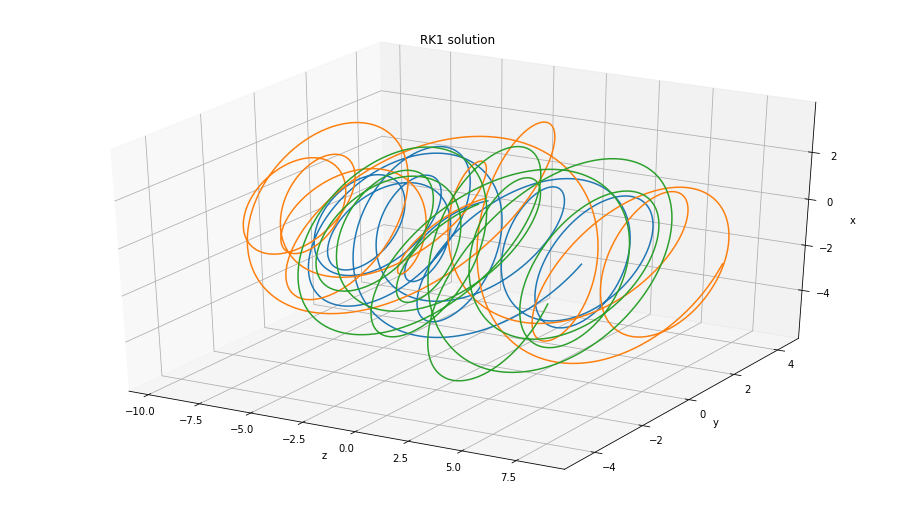

In [6]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

for data in traectories_rk1[:3]:
    ax.plot(xs=data[2], ys=data[1], zs=data[0])
    
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.set_zlabel("x")

ax.set_title("RK1 solution")

Для метода Рунге-Кутты четвертого порядка

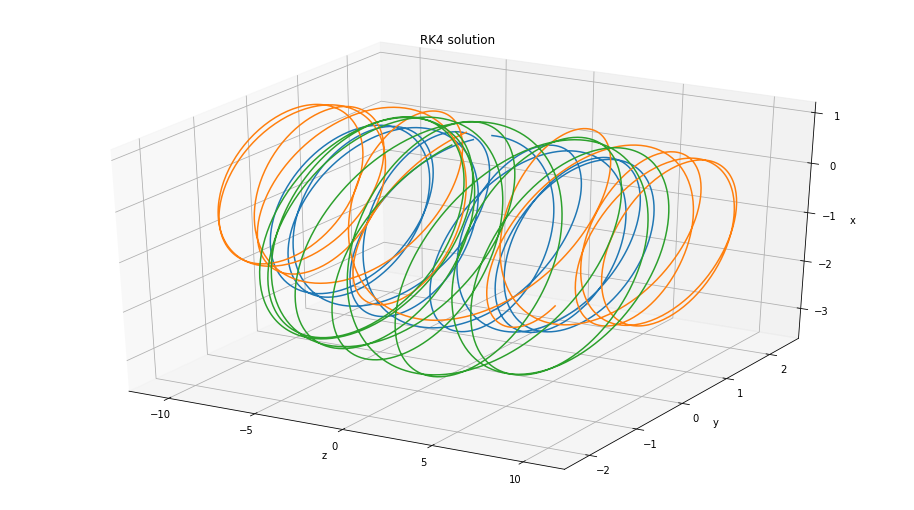

In [7]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

for data in traectories_rk4[:3]:
    ax.plot(xs=data[2], ys=data[1], zs=data[0])
    
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.set_zlabel("x")

ax.set_title("RK4 solution")

Анимируем облако частиц для лучшего восприятия

Для метода RK1:

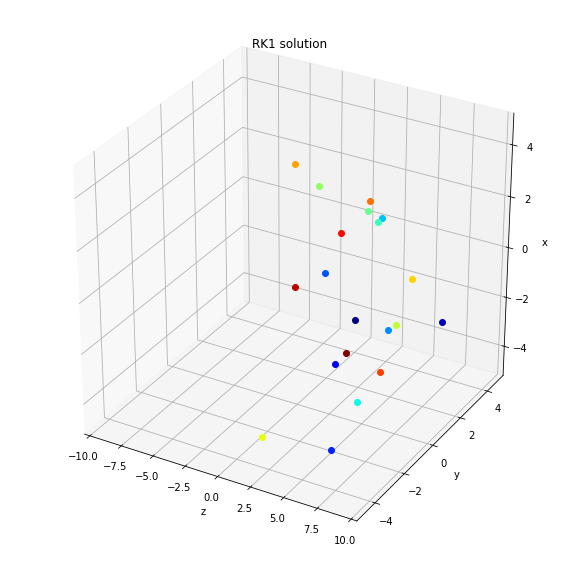

In [8]:
from matplotlib import animation, rc
from IPython.display import HTML

data = traectories_rk1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("z")
ax.set_ylabel("y")
ax.set_zlabel("x")

ax.set_title("RK1 solution")

ax.set_xlim(( -10, 10))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))

colors = plt.cm.jet(linspace(0, 1, len(data)))

pts = [ax.plot([], [], [], 'o', c=c)[0]
           for c in colors]

def init():
    for pt in pts:
        pt.set_data([], [])
        pt.set_3d_properties([])
    return pts

def animate(i):
    for dt, pt in zip(data, pts):
        x = dt[2][i]
        y = dt[1][i]
        z = dt[0][i]
        pt.set_data(x, y)
        pt.set_3d_properties(z)
    return pts

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N_iter, interval=10, blit=True)

HTML(anim.to_html5_video())


Для метода RK4:

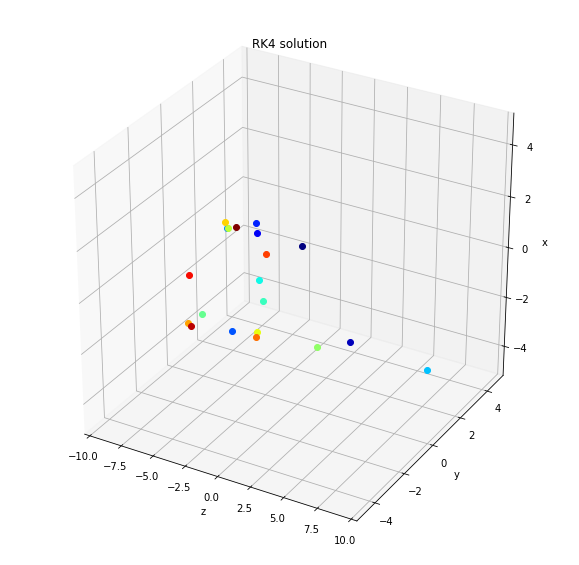

In [9]:
from matplotlib import animation, rc
from IPython.display import HTML

data = traectories_rk4

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(( -10, 10))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))

ax.set_xlabel("z")
ax.set_ylabel("y")
ax.set_zlabel("x")

ax.set_title("RK4 solution")

colors = plt.cm.jet(linspace(0, 1, len(data)))

pts = [ax.plot([], [], [], 'o', c=c)[0]
           for c in colors]

def init():
    for pt in pts:
        pt.set_data([], [])
        pt.set_3d_properties([])
    return pts

def animate(i):
    for dt, pt in zip(data, pts):
        x = dt[2][i]
        y = dt[1][i]
        z = dt[0][i]
        pt.set_data(x, y)
        pt.set_3d_properties(z)
    return pts

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N_iter, interval=10, blit=True)

HTML(anim.to_html5_video())

Согласно физическому смыслу задачи, все траектории частиц должны быть финитны. Убедимся на графиках в финитности траекторий частиц:

Для метода RK1

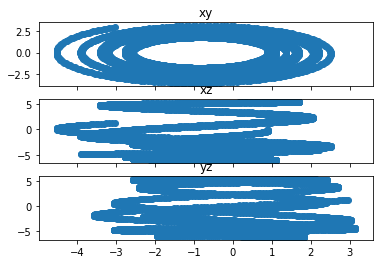

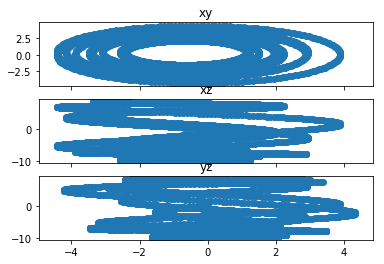

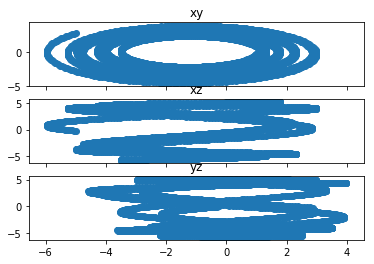

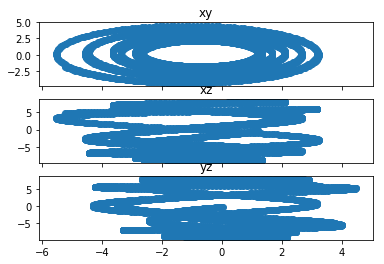

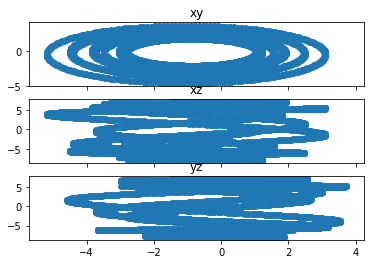

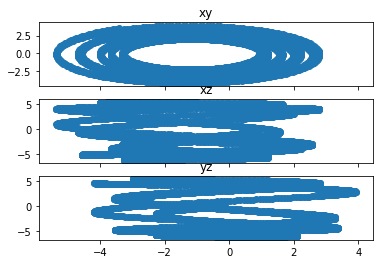

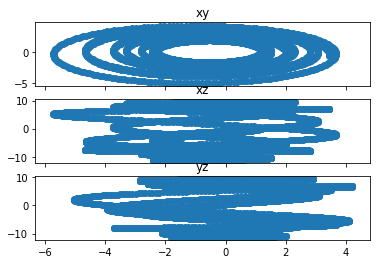

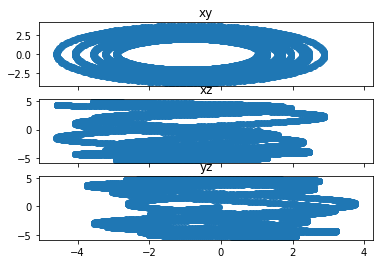

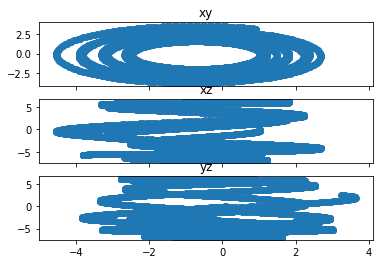

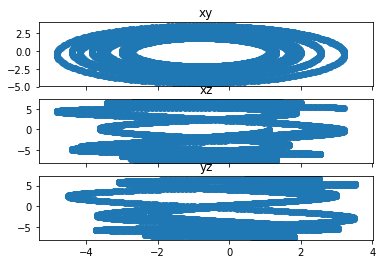

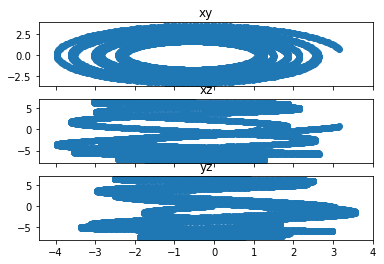

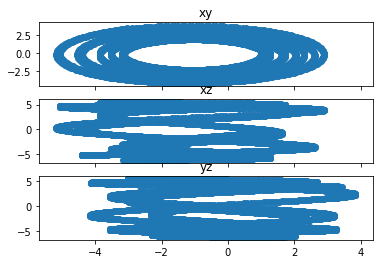

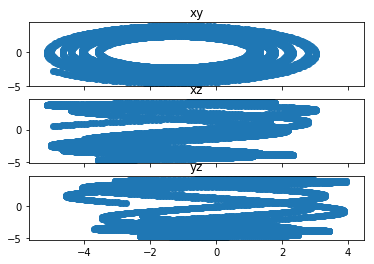

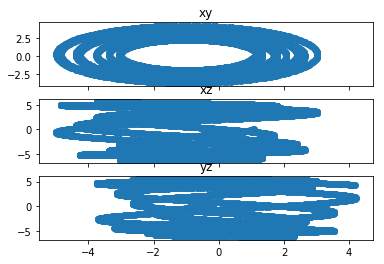

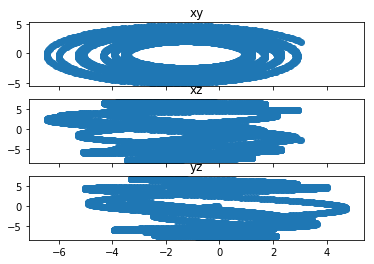

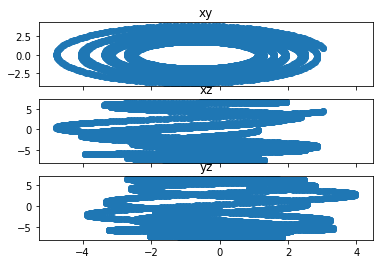

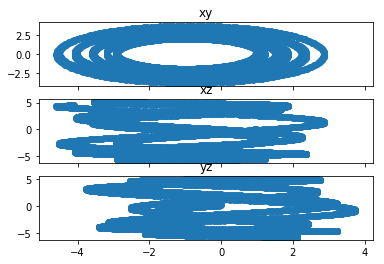

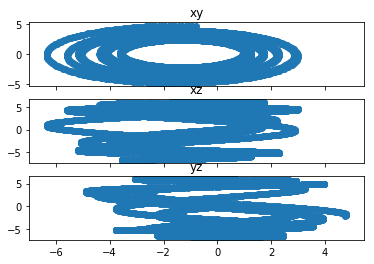

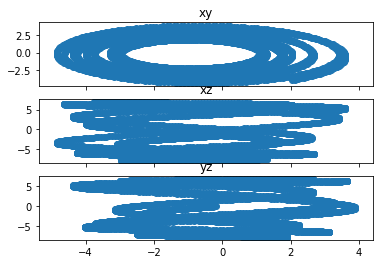

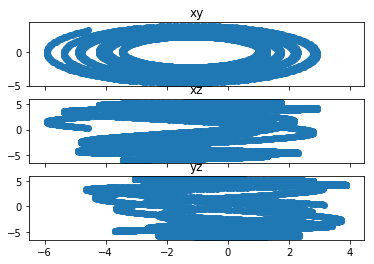

In [10]:
for traectory in traectories_rk1:
    f, ax = plt.subplots(3, sharex=True)
    ax[0].scatter(traectory[0], traectory[1])
    ax[0].set_title("xy")
    ax[1].scatter(traectory[0], traectory[2])
    ax[1].set_title("xz")
    ax[2].scatter(traectory[1], traectory[2])
    ax[2].set_title("yz")

Для метода RK4

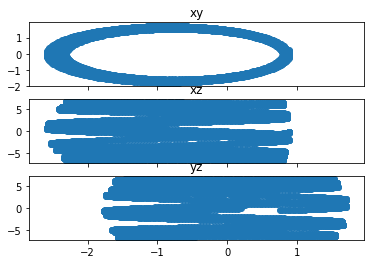

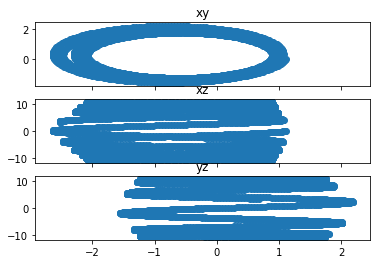

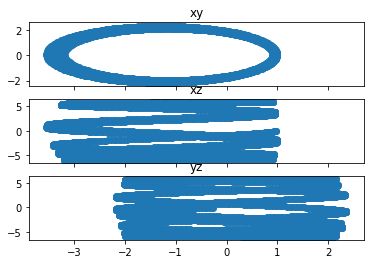

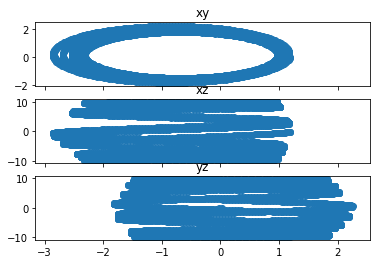

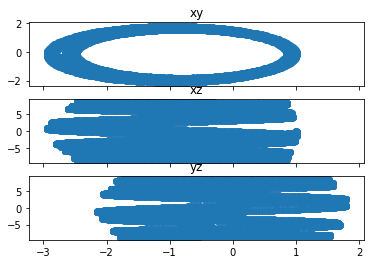

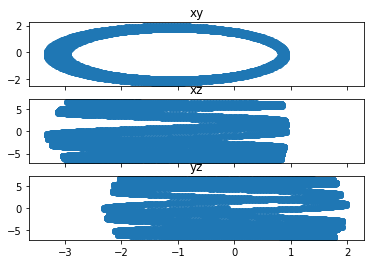

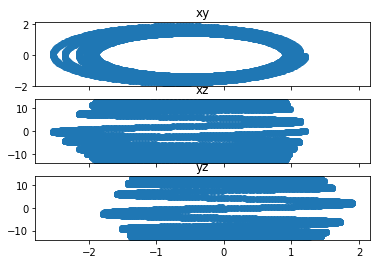

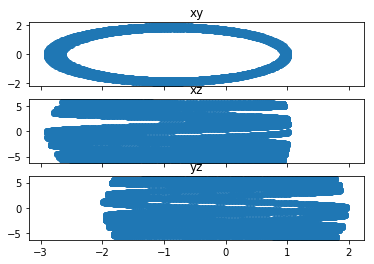

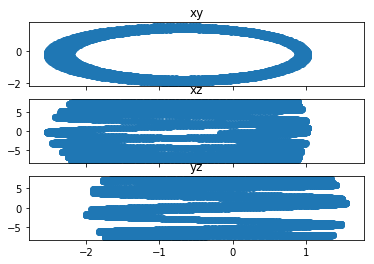

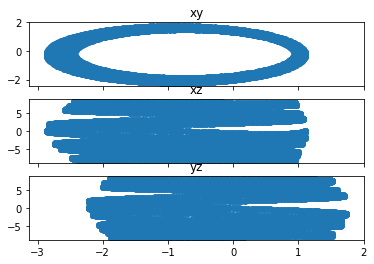

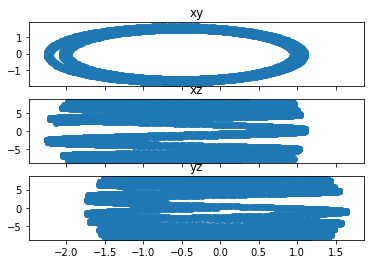

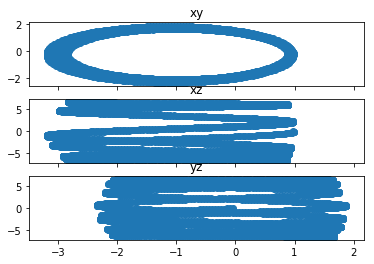

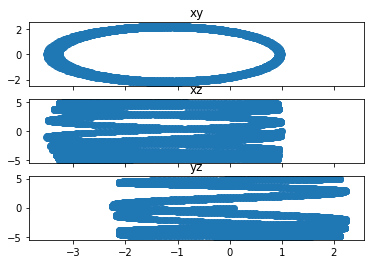

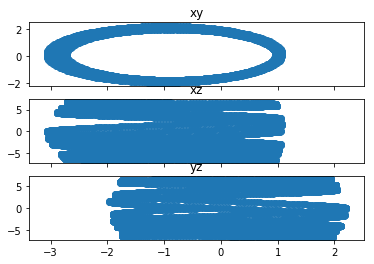

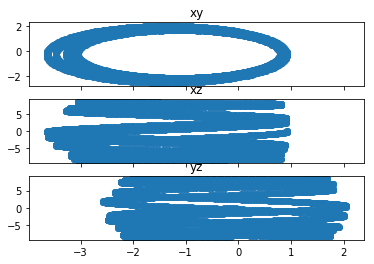

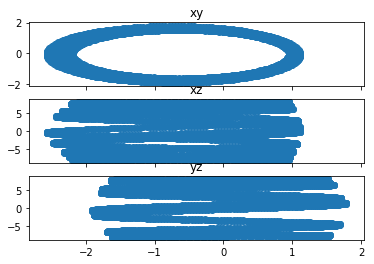

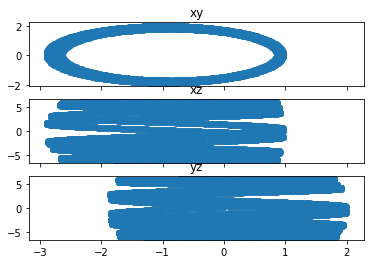

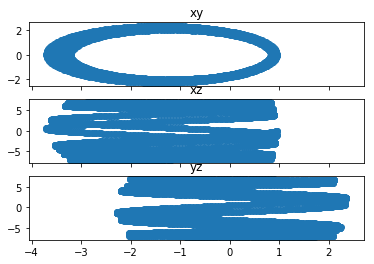

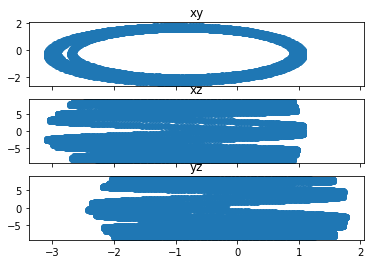

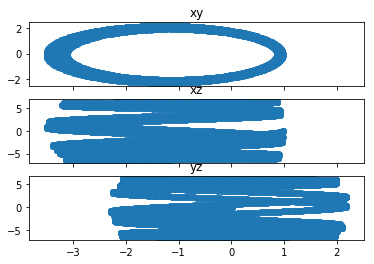

In [11]:
for traectory in traectories_rk4:
    f, ax = plt.subplots(3, sharex=True)
    ax[0].scatter(traectory[0], traectory[1])
    ax[0].set_title("xy")
    ax[1].scatter(traectory[0], traectory[2])
    ax[1].set_title("xz")
    ax[2].scatter(traectory[1], traectory[2])
    ax[2].set_title("yz")

## Исследование сходимости методов при $h \to 0$ по сетке

Рассмотрим сходимость методов при шаге $h \to 0$

In [12]:
h = 0.01
conv_data_rk1 = [getParticleTraectory(rk1, N_iter*(2**i), particles[0], h/(2**i)) for i in range(6)]
conv_data_rk4 = [getParticleTraectory(rk4, N_iter*(2**i), particles[0], h/(2**i)) for i in range(6)]

In [14]:
convergence_rk1 = []
for i, (a, b) in enumerate(zip(conv_data_rk1, conv_data_rk1[1:])):
    x0 = []
    y0 = []
    z0 = []
    x1 = []
    y1 = []
    z1 = []
    step = 2**i
    for j in range(N_iter):
        x0.append(a[0][j*step])
        y0.append(a[1][j*step])
        z0.append(a[2][j*step])
        
    step = 2**(i+1)
    for j in range(N_iter):
        x1.append(b[0][j*step])
        y1.append(b[1][j*step])
        z1.append(b[2][j*step])
        
    x0 = array(x0)
    y0 = array(y0)
    z0 = array(z0)
    x1 = array(x1)
    y1 = array(y1)
    z1 = array(z1)
        
    convergence_rk1.append(sum(sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)))

In [15]:
convergence_rk4 = []
for i, (a, b) in enumerate(zip(conv_data_rk4, conv_data_rk4[1:])):
    x0 = []
    y0 = []
    z0 = []
    x1 = []
    y1 = []
    z1 = []
    step = 2**i
    for j in range(N_iter):
        x0.append(a[0][j*step])
        y0.append(a[1][j*step])
        z0.append(a[2][j*step])
        
    step = 2**(i+1)
    for j in range(N_iter):
        x1.append(b[0][j*step])
        y1.append(b[1][j*step])
        z1.append(b[2][j*step])
        
    x0 = array(x0)
    y0 = array(y0)
    z0 = array(z0)
    x1 = array(x1)
    y1 = array(y1)
    z1 = array(z1)
        
    convergence_rk4.append(sum(sqrt((x1-x0)**2 + (y1-y0)**2 + (z1-z0)**2)))

Представим на графиках зависимость погрешности решения в зависимости от шага. Видим, что разница между начальными ошибками двух методов составляет восемь порядков, что и ожидалось видеть при начальном шаге порядка 0.05 для методов первого и четвертого порядка. Вид зависимости так же совпадает с ожиданиями (~ $\frac{1}{h}$ и $\frac{1}{h^4}).$

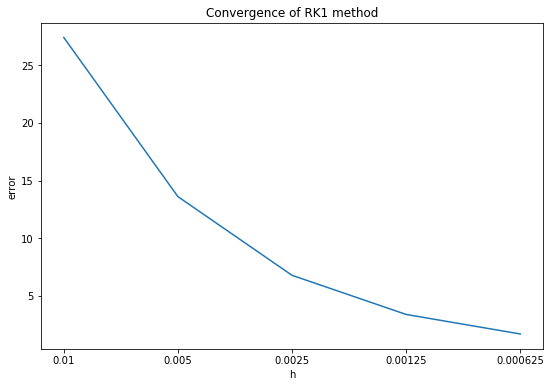

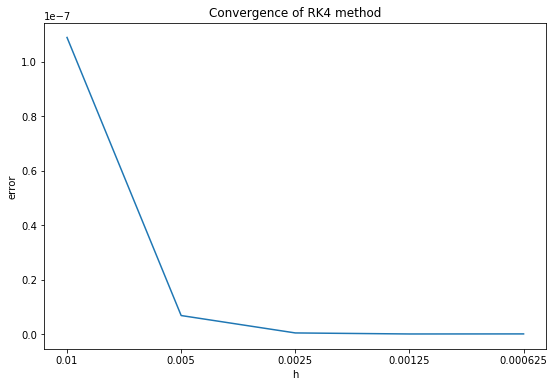

In [18]:
plt.figure(figsize=(9, 6))
plt.xlabel("h")
plt.ylabel("error")
plt.title("Convergence of RK1 method")
plt.xticks(range(5), [h/(2**i) for i in range(5)])
plt.plot(array(convergence_rk1))
plt.show()
plt.figure(figsize=(9, 6))
plt.plot(array(convergence_rk4))
plt.xticks(range(5), [h/(2**i) for i in range(5)])
plt.xlabel("h")
plt.ylabel("error")
plt.title("Convergence of RK4 method") 

Рассмотрим отношение ошибок методов для каждого шага.

In [19]:
for i, (a, b) in enumerate(zip(convergence_rk4, convergence_rk1)):
    print("h = ", h/(2**i), ": RK4/RK0 = ", a/b)

h =  0.01 : RK4/RK0 =  3.9717921508e-09
h =  0.005 : RK4/RK0 =  5.00266934549e-10
h =  0.0025 : RK4/RK0 =  6.20010472768e-11
h =  0.00125 : RK4/RK0 =  1.16433853646e-11
h =  0.000625 : RK4/RK0 =  3.84029562382e-11


В реальности разница в порядке ошибки оказалась даже больше, чем ожидалось исходя из ассимптотик.